In [1]:
import sys

sys.path.append('../')
from boom.msBO import MultiStateBO
from boom.objective import BPMvar_minimization

import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('../../machineIO/')
from machineIO import construct_machineIO, VirtualMachineIO, StatefulOracleEvaluator

np.random.seed(3)
torch.manual_seed(3)

# import importlib, msBO  # or from boom import msBO if that's your import
# importlib.reload(msBO)

Failed to import 'epics'
Failed to import 'phantasy'


In [2]:
ntry = 30
n_init = 10
n_each = 5
beta = 9

In [3]:
n_control = 8
n_bpm = 2
n_monitor = n_bpm*2
n_task = n_bpm+1
n_state = 3
n_state_pvs = 1

control_CSETs = [f'PSC{i}:I_CSET' for i in range(n_control)]
control_RDs  = [f'PSC{i}:I_RD' for i in range(n_control)]
control_tols = [0.01]*len(control_CSETs)
control_min  = [ 0.0]*len(control_CSETs)
control_max  = [ 1.0]*len(control_CSETs)
bpm_xRDs     = [f'BPM{i}:XPOS_RD' for i in range(n_bpm)]
bpm_magRDs   = [f'BPM{i}:MAG_RD' for i in range(n_bpm)]
monitor_RDs  = bpm_xRDs + bpm_magRDs
state_CSETs  = [f'CSS:POS{i}_CSET' for i in range(n_state_pvs)]
state_RDs    = [f'CSS:POS{i}_RD' for i in range(n_state_pvs)]
state_tols   = [0.01]*len(state_CSETs)
state_min    = [0.0]*n_state_pvs
state_max    = [n_state-1]*n_state_pvs
state_key_vals  = {f'state{s}':[float(s)]*n_state_pvs for s in range(n_state)}
oracle_key_names = {'x':control_RDs,
                    'y':bpm_xRDs + ['BPM:MAG_min_ratio']}
states = list(state_key_vals.keys())

In [4]:
# 
# x0 = np.concatenate([x0,state_key_vals['state0']])
vmIO = VirtualMachineIO(
    control_CSETs = control_CSETs + state_CSETs,
    control_RDs = control_RDs + state_RDs,
    monitor_RDs = monitor_RDs,
    control_min = control_min + state_min,
    control_max = control_max + state_max,
    monitor_min = [-5.0]*n_bpm + [0.8]*n_bpm,
    monitor_max = [ 5.0]*n_bpm + [1.0]*n_bpm,
    complexity  = 128,
)

In [5]:
x0 = np.random.rand(len(control_CSETs))*(np.asarray(control_max) - np.asarray(control_min)) + np.asarray(control_min)
print("x0",x0)
BPM_MAGs_ref = {}
for s,v in state_key_vals.items():
    _ = vmIO.ensure_set(vmIO.control_CSETs, vmIO.control_RDs, np.concatenate([x0,v]), control_tols + state_tols)
    y = vmIO.fetch_data(bpm_magRDs).mean().values
    BPM_MAGs_ref[s] = y
BPM_MAGs_ref

x0 [0.27610464 0.44233649 0.5780937  0.75118104 0.67053434 0.40614139
 0.74524316 0.02896002]


{'state0': array([0.92817982, 0.90689454]),
 'state1': array([0.92318055, 0.89501934]),
 'state2': array([0.90592082, 0.88953063])}

In [6]:
def BPM_MAG_obj(df,s):
    # print('before')
    # print(df.mean())
    df['BPM:MAG_min_ratio'] = (df[bpm_magRDs].values/BPM_MAGs_ref[s][None,:]).min()
    # print('after')
    # print(df.mean())
    return df

In [7]:
oracleEvaluator = StatefulOracleEvaluator(
    vmIO,
    control_CSETs= control_CSETs,
    control_RDs  = control_RDs,
    control_tols = control_tols,
    state_CSETs  = state_CSETs,
    state_RDs    = state_RDs,
    state_tols   = state_tols,
    state_key_vals = state_key_vals,
    oracle_key_names = oracle_key_names,
    monitor_RDs  = monitor_RDs,
    state_df_manipulators = [BPM_MAG_obj],
)

In [8]:
composite_objective_function = BPMvar_minimization(S=n_state, J=n_task)

In [9]:
def run_once(seed,x0=x0,acq_type = 'EI',fix_acq_state = False,local_optimization=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    oracleEvaluator(x=x0,s=states[0])
    
    msbo = MultiStateBO(
        states = states,
        tasks  = oracle_key_names['y'], 
        control_min = control_min,
        control_max = control_max,
        multistate_oracle_evaluator = oracleEvaluator,
        composite_objective_function = composite_objective_function,
        local_bound_size = 0.1*(np.asarray(control_max) - np.asarray(control_min))
        )
    msbo.init(n_init=n_init, local_optimization=local_optimization)
    for s in states[::-1]:
        for i in range(n_each):
            msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
    for s in states:
        for i in range(n_each-1):
            msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
    for s in states:
        for i in range(n_each-2):
            msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
    for s in states[::-1]:
        for i in range(n_each-3):
            msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
            
    # fig,ax,vobj_mean = msbo.plot_composite_objective()        
    iters, means, stds = msbo.virtual_composite_history()
    return means

In [10]:
benchmark = {}
for acq_type in ['EI','UCB']:
    for fix_acq_state in [False, True]:
        for local_optimization in [False,True]:
            key = f'{acq_type}_fixS:{fix_acq_state}_local:{local_optimization}'
            print(key)
            benchmark[key] = []
            for seed in range(ntry):
                vobjmean = run_once(seed,x0=x0,acq_type=acq_type,fix_acq_state=fix_acq_state,local_optimization=local_optimization)
                benchmark[key].append(vobjmean)

EI_fixS:False_local:False
EI_fixS:False_local:True
EI_fixS:True_local:False


C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected ran

EI_fixS:True_local:True


C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\botorch\optim\initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected ran

UCB_fixS:False_local:False
UCB_fixS:False_local:True
UCB_fixS:True_local:False
UCB_fixS:True_local:True


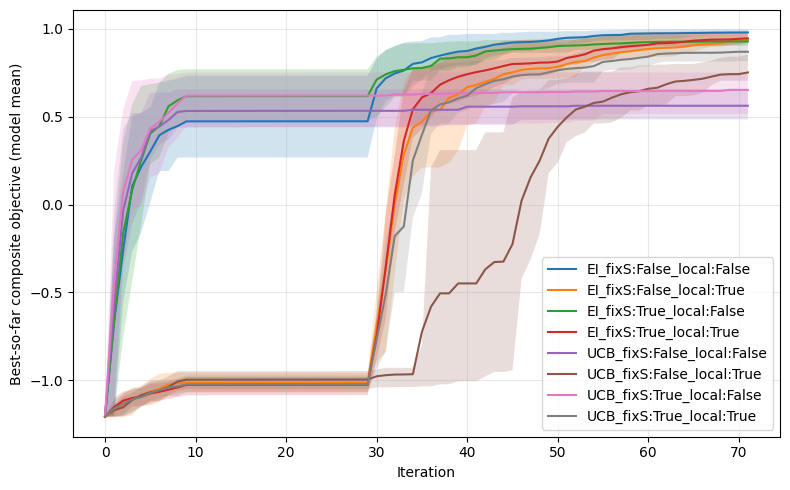

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def cumulative_best(y, mode='max'):
    """Best-so-far over iterations (min for minimization, max for maximization)."""
    y = np.asarray(y, dtype=float)
    if mode == 'min':
        return np.minimum.accumulate(y)
    elif mode == 'max':
        return np.maximum.accumulate(y)
    else:
        raise ValueError("mode must be 'min' or 'max'.")

def align_trials(trials):
    """
    Stack trials to (n_trials, T_common) by truncating to the shortest length.
    Assumes each trial is a 1D sequence over iterations.
    """
    L = min(len(t) for t in trials)
    arr = np.stack([np.asarray(t[:L], dtype=float) for t in trials], axis=0)
    return arr  # shape: (n_trials, L)

def summarize_over_trials(arr):
    """Return mean, 10th, 90th percentiles across trials at each iteration."""
    mean = np.nanmean(arr, axis=0)
    q20  = np.nanquantile(arr, 0.20, axis=0)
    q80  = np.nanquantile(arr, 0.80, axis=0)
    return mean, q20, q80

# ---------- compute BSF stats for every key ----------
# If lower is better (typical), keep mode='min'. Change to 'max' if needed.
mode = 'max'

summaries = {}
common_T = None
for key, trials in benchmark.items():
    # Each `trials` is a list of vobj_mean sequences (one per run)
    bsf_trials = [cumulative_best(v, mode=mode) for v in trials]
    arr = align_trials(bsf_trials)  # (n_trials, T)
    mean, q20, q80 = summarize_over_trials(arr)
    summaries[key] = dict(mean=mean, q20=q20, q80=q80)
    if common_T is None:
        common_T = len(mean)

# ---------- plot ----------
plt.figure(figsize=(8, 5))
iters = np.arange(common_T)
for key, stats in summaries.items():
    m, lo, hi = stats['mean'], stats['q20'], stats['q80']
    plt.plot(iters, m, label=key)
    plt.fill_between(iters, lo, hi, alpha=0.2)

plt.xlabel('Iteration')
plt.ylabel('Best-so-far composite objective (model mean)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


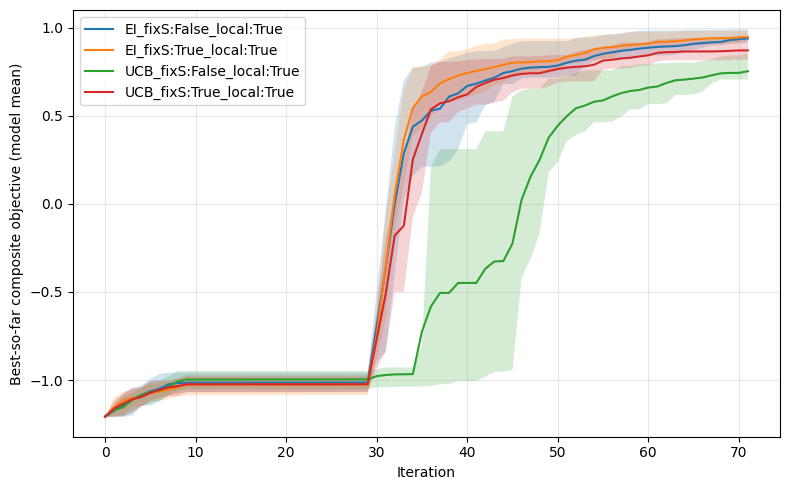

In [12]:
mode = 'max'

summaries = {}
common_T = None
for key, trials in benchmark.items():
    if "False" == key[-5:]:
        continue
        # Each `trials` is a list of vobj_mean sequences (one per run)
    bsf_trials = [cumulative_best(v, mode=mode) for v in trials]
    arr = align_trials(bsf_trials)  # (n_trials, T)
    mean, q20, q80 = summarize_over_trials(arr)
    summaries[key] = dict(mean=mean, q20=q20, q80=q80)
    if common_T is None:
        common_T = len(mean)

# ---------- plot ----------
plt.figure(figsize=(8, 5))
iters = np.arange(common_T)
for key, stats in summaries.items():
    m, lo, hi = stats['mean'], stats['q20'], stats['q80']
    plt.plot(iters, m, label=key)
    plt.fill_between(iters, lo, hi, alpha=0.2)

plt.xlabel('Iteration')
plt.ylabel('Best-so-far composite objective (model mean)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
